# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [1]:
!python -m pip install --user --upgrade pip

In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
from sklearn.datasets import fetch_california_housing
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.get_logger().warning('test')
import tensorflow_addons as tfa
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.utils import plot_model

# Model selection
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Evaluation metrics
from sklearn import metrics

In [3]:
def reshape_1Dto2Dseq(df, seq_length):
    # 2D X & Y split
    X_reshape, Y_reshape = [], []
    for index in range(len(df) - seq_length): # 2D: seq_length+1
        X_reshape.append(np.array(df[index: index + seq_length]))
        Y_reshape.append(np.ravel(df[index + seq_length:index + seq_length + 1])) # 2D(first): seq_length-1
    X_reshape, Y_reshape = np.array(X_reshape), np.array(Y_reshape)    
    
    # reshape
    X_reshape = pd.DataFrame(X_reshape.reshape(X_reshape.shape[0], -1), index=df.index[seq_length:])
    Y_reshape = pd.DataFrame(Y_reshape, columns=df.columns, index=df.index[seq_length:])
    
    return X_reshape, Y_reshape


def datasplit_cross_traintest(df, Y_colname, test_ratio, 
                              random_seed=123, shape_show=True):
    # setting
    X_colname = [i for i in df.columns if i not in Y_colname]
    
    # train / test / X / Y split
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], 
                                                        df[Y_colname], 
                                                        test_size=test_ratio,
                                                        random_state=random_seed)
    
    # result
    if shape_show:
        print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
        print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


def datasplit_timeseries_ratio(df, Y_colname, test_ratio=0.4, 
                               shape_show=True):
    # setting
    test_size = int(df.shape[0] * test_ratio)
    
    # train / test split
    df_train = df.iloc[:-test_size,:]
    df_test = df.iloc[-test_size:,:]
    
    # X / Y split
    X_colname = [i for i in df.columns if i not in Y_colname]
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_test = df_test[Y_colname]
    X_test = df_test[X_colname]
    
    # result
    if shape_show:
        print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
        print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


def reshape_2Dto3Dseq(df_X, df_Y, seq_length):
    # generate sequence
    X_reshape, Y_reshape = [], []
    for index in range(len(df_X) - seq_length + 1):
        X_reshape.append(np.array(df_X[index: index + seq_length]))
        Y_reshape.append(np.ravel(df_Y[index + seq_length - 1:index + seq_length]))
    X_reshape, Y_reshape = np.array(X_reshape), np.array(Y_reshape)
    
    # reshape
    X_reshape = X_reshape.reshape(X_reshape.shape[0], seq_length, -1)
    Y_reshape = pd.DataFrame(Y_reshape, index=df_Y.index[seq_length-1:], columns=df_Y.columns)
    
    return X_reshape, Y_reshape


# Learning Plot
def evaluation_reg_LearningPlot(fit_class, figsize=(10,3), 
                            label_first='Training', label_second='Validation'):
    for i in range(int(len(fit_class.history.keys())/2)):
        if i == 0:
            # Loss Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['loss'], color='b', 
                     label=label_first+' Loss')
            plt.plot(fit_class.history['val_loss'], color='r', 
                     label=label_second+' Loss')
        elif i == 1:
            # MAE Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['mae'], color='b', 
                     label=label_first+' MAE')
            plt.plot(fit_class.history['val_mae'], color='r', 
                     label=label_second+' MAE')
        elif i == 2:
            # MSE Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['mse'], color='b', 
                     label=label_first+' MSE')
            plt.plot(fit_class.history['val_mse'], color='r', 
                     label=label_second+' MSE')
        else:
            # MAPE Plot
            plt.figure(figsize=figsize)
            plt.plot(fit_class.history['mape'], color='b', 
                     label=label_first+' MAPE')
            plt.plot(fit_class.history['val_mape'], color='r', 
                     label=label_second+' MAPE')
        plt.xlabel('Epoch', fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(loc='best', shadow=True, fontsize=12)
        plt.show()
        
        
def evaluation_reg_MAE_MSE_MAPE(Y_real, Y_pred):
    # length check
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    
    # evaluator
    MAE = metrics.mean_absolute_error(Y_real, Y_pred)
    MSE = metrics.mean_squared_error(Y_real, Y_pred)
    MAPE = metrics.mean_absolute_percentage_error(Y_real, Y_pred)
    
    # rearrange
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = Y_real - Y_pred
    
    return Score, Residual
        
        
def evaluation_reg_PredPlot(Y_real, Y_pred, title='Algorithm',
                        xlabel='Sequence', ylabel='Price'):
    df_Y = pd.concat([Y_real, pd.DataFrame(Y_pred, 
                                           index=Y_real.index)], axis=1)
    df_Y.columns = ['Real Value', 'Predicted Value']
    df_Y.plot(kind='line', figsize=(18,6), linewidth=3, fontsize=20,
              xlim=(Y_real.index.min(),Y_real.index.max()))
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.legend(fontsize=16)
    plt.grid()
    plt.show()


def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf


def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss


def error_analysis(Y_Data, X_Data, graph_on=False):
#     X_Data = X_Data.loc[Y_Data.index] # for Bitcoin

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Y_Data.columns[0], data=Y_Data, line_kws={'color': 'red'},
                   fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Y_Data.columns[0]], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Y_Data.columns[0]])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Y_Data.columns[0]], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Y_Data.columns[0]], lags=50, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Y_Data.columns[0]], lags=50, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Y_Data.columns[0])
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Y_Data.columns[0])

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Y_Data.columns[0]])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Y_Data.columns[0]], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Y_Data.columns[0]], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Y_Data.columns[0]], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    
    return Score

# Deep Learning: Bitcoin Prediction

## Parameters Setting

In [4]:
Y_colname = ['Bitcoin']
scaler = preprocessing.MinMaxScaler()
tf.random.set_seed(123)
TEST_RATIO = 0.1
SEQUENCE = 10 # not MLP
DROPOUT_RATIO = 0.2
BATCH_SIZE = 32
EPOCHS = 50 # 100
VERBOSE = 0
# Callback Direct
EARLYSTOP_PATIENT = 10
CALLBACK = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
#################
RESULT_LOCATION = os.path.join(os.getcwd(),'Result','Bitcoin_')
RESULT_DPI = 150
ALGO_NAMES = ['MLP', 'CNN', 'RNN', 'LSTM', 'GRU']

## MLP

X_train: (2162, 10) Y_train: (2162, 1)
X_val: (120, 10) Y_val: (120, 1)
X_test: (120, 10) Y_test: (120, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729


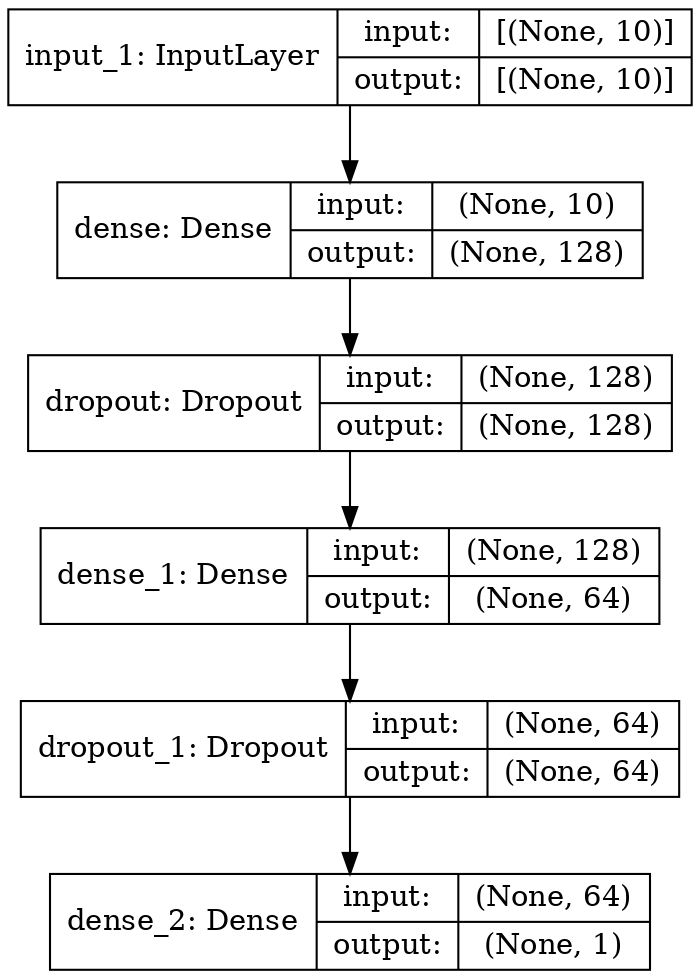

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

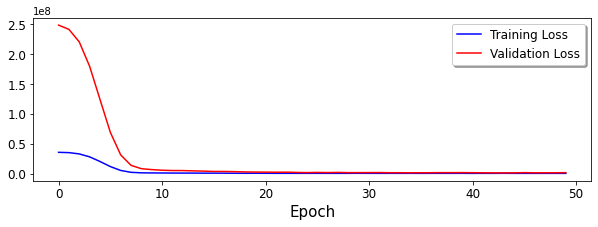

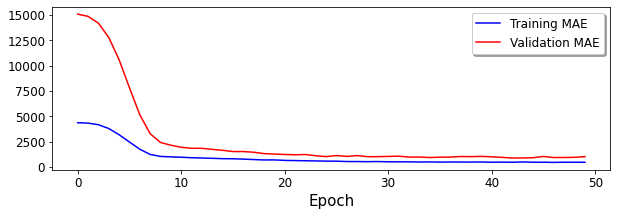

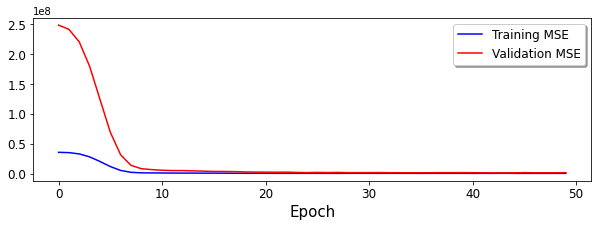

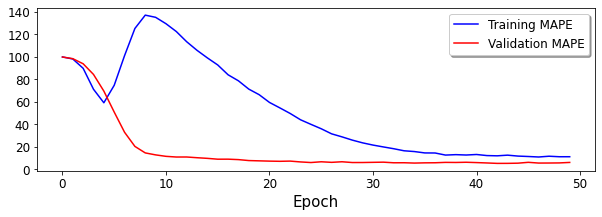

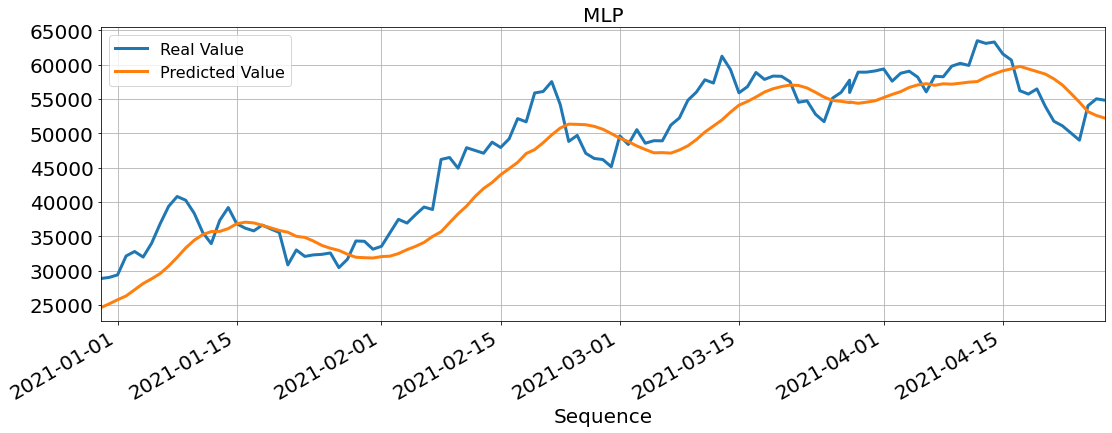

MAE           MSE  MAPE
Score 3,657.28 19,029,147.35  0.08

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.13               0.17       0.99   
p-value                                   0.02               0.10       0.23   
Used Lag                                  0.00              13.00        NaN   
Used Observations                       119.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,921.88                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        88.19          214.93           224.65   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        439.52               0.82  
p-value                                  0.00               0.47  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

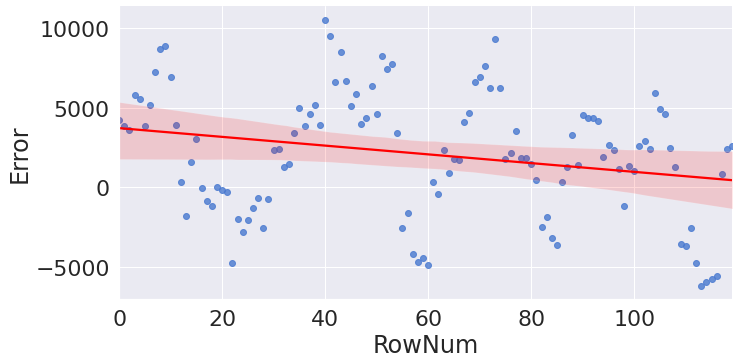

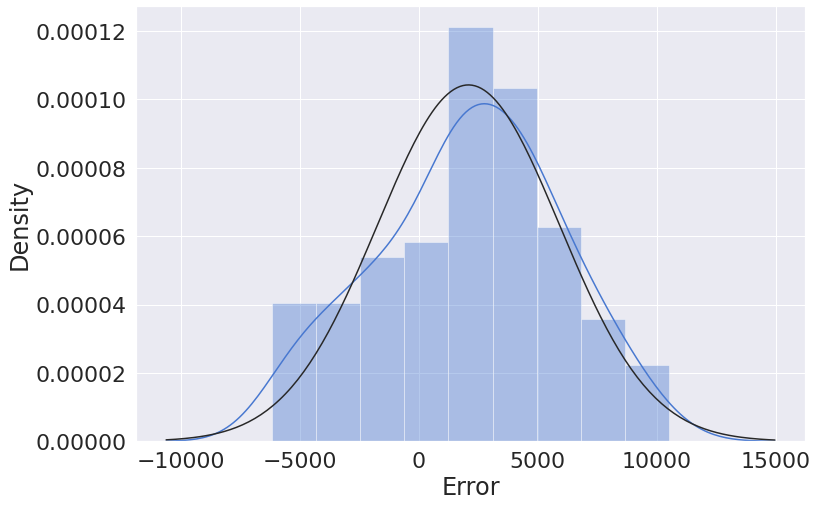

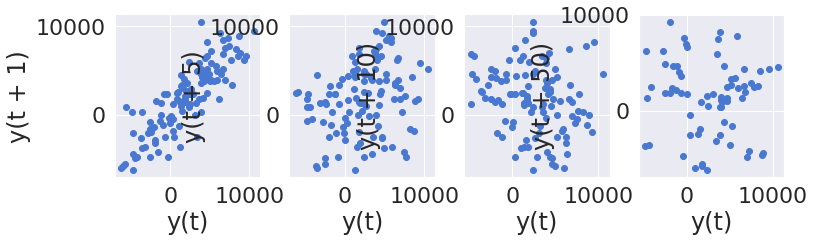

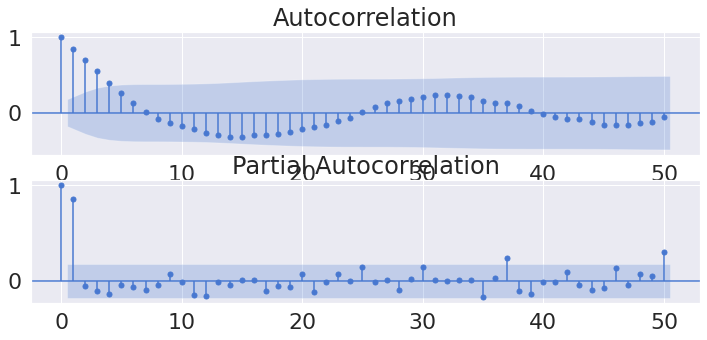

In [5]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','CryptoCurrency','Bitcoin.csv')
df = pd.read_csv(location, index_col='Date')
df.index = pd.to_datetime(df.index)
df = df[['Close']].copy()

# Reshape
df_X, df_Y = reshape_1Dto2Dseq(df, seq_length=SEQUENCE)
df_Y.columns = Y_colname
df = pd.concat([df_Y, df_X], axis=1)

# Preprocessing
X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
X_colname = X_test.columns

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# MLP
inputs = Input(shape=(X_train.shape[1],))
hiddens = Dense(128, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = Dense(256, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = Dense(128, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Dense(64, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1)(hiddens)
algo_MLP = Model(inputs, outputs)
algo_MLP.summary()
display(plot_model(algo_MLP, to_file=RESULT_LOCATION+'MLP.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'MLP.h5')]

algo_MLP.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_MLPfit = algo_MLP.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_MLPfit)

# Prediction
Y_pred = algo_MLP.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='MLP', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test = pd.DataFrame(X_test, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test, graph_on=True)
display(ErrorResult)

# Summary
Score_MLP = Score.copy()
Y_pred_MLP = Y_pred.copy()
Error_MLP = ErrorResult.copy()

### Load Best Learning

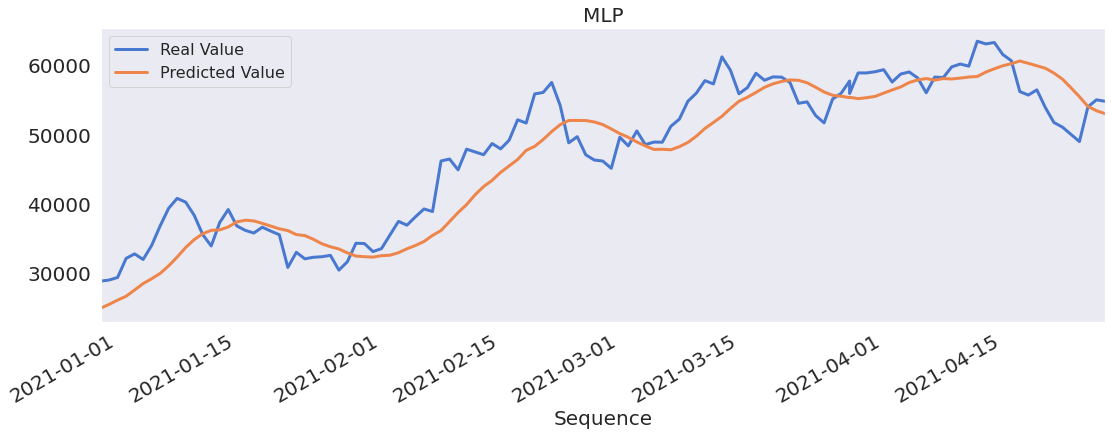

MAE           MSE  MAPE
Score 3,434.79 17,306,766.39  0.08

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.07               0.21       0.99   
p-value                                   0.03               0.10       0.26   
Used Lag                                  0.00              13.00        NaN   
Used Observations                       119.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,922.45                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        89.41          221.76           231.17   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        445.65               0.82  
p-value                                  0.00               0.47  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

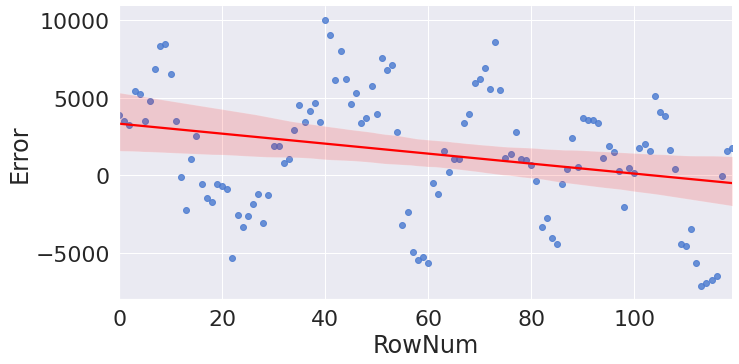

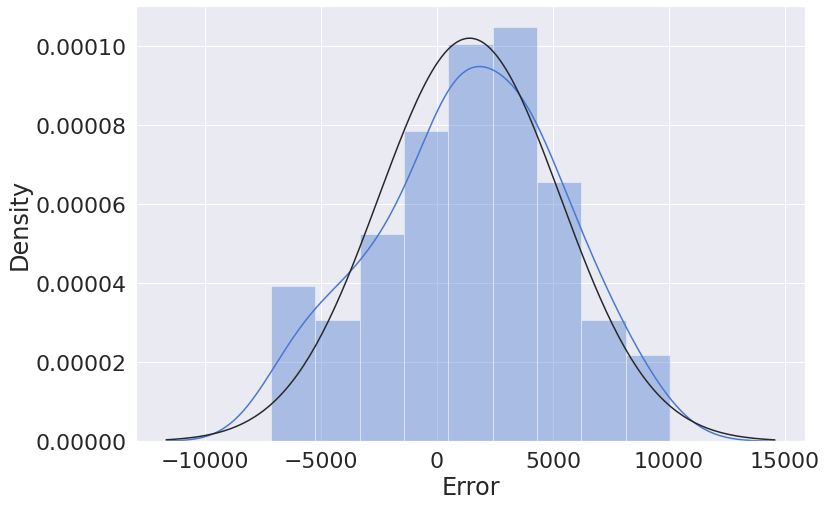

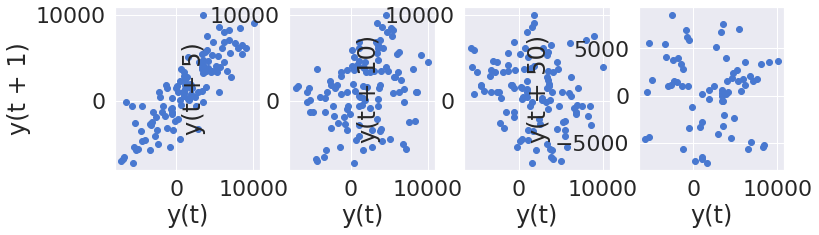

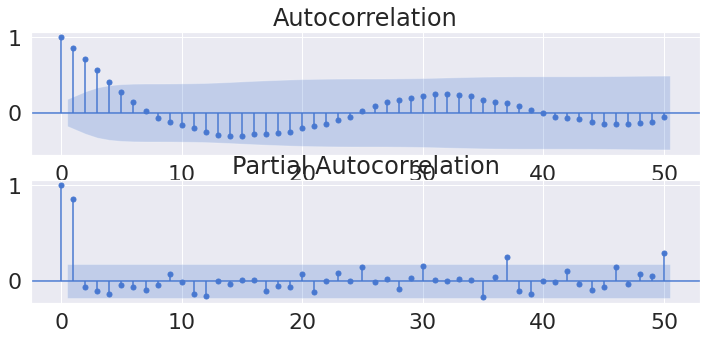

In [6]:
# Loading of Best Learning 
algo_MLP = load_model(RESULT_LOCATION+'MLP.h5')

# Prediction
Y_pred = algo_MLP.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='MLP', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test = pd.DataFrame(X_test, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test, graph_on=True)
display(ErrorResult)

# Summary
Score_MLP = Score.copy()
Y_pred_MLP = Y_pred.copy()
Error_MLP = ErrorResult.copy()

## CNN

X_train: (2162, 10) Y_train: (2162, 1)
X_val: (120, 10) Y_val: (120, 1)
X_test: (120, 10) Y_test: (120, 1)
X_train: (2162, 10, 1) Y_train: (2162, 1)
X_val: (120, 10, 1) Y_val: (120, 1)
X_test: (120, 10, 1) Y_test: (120, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 128)           1408      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             81984     
__________________________________

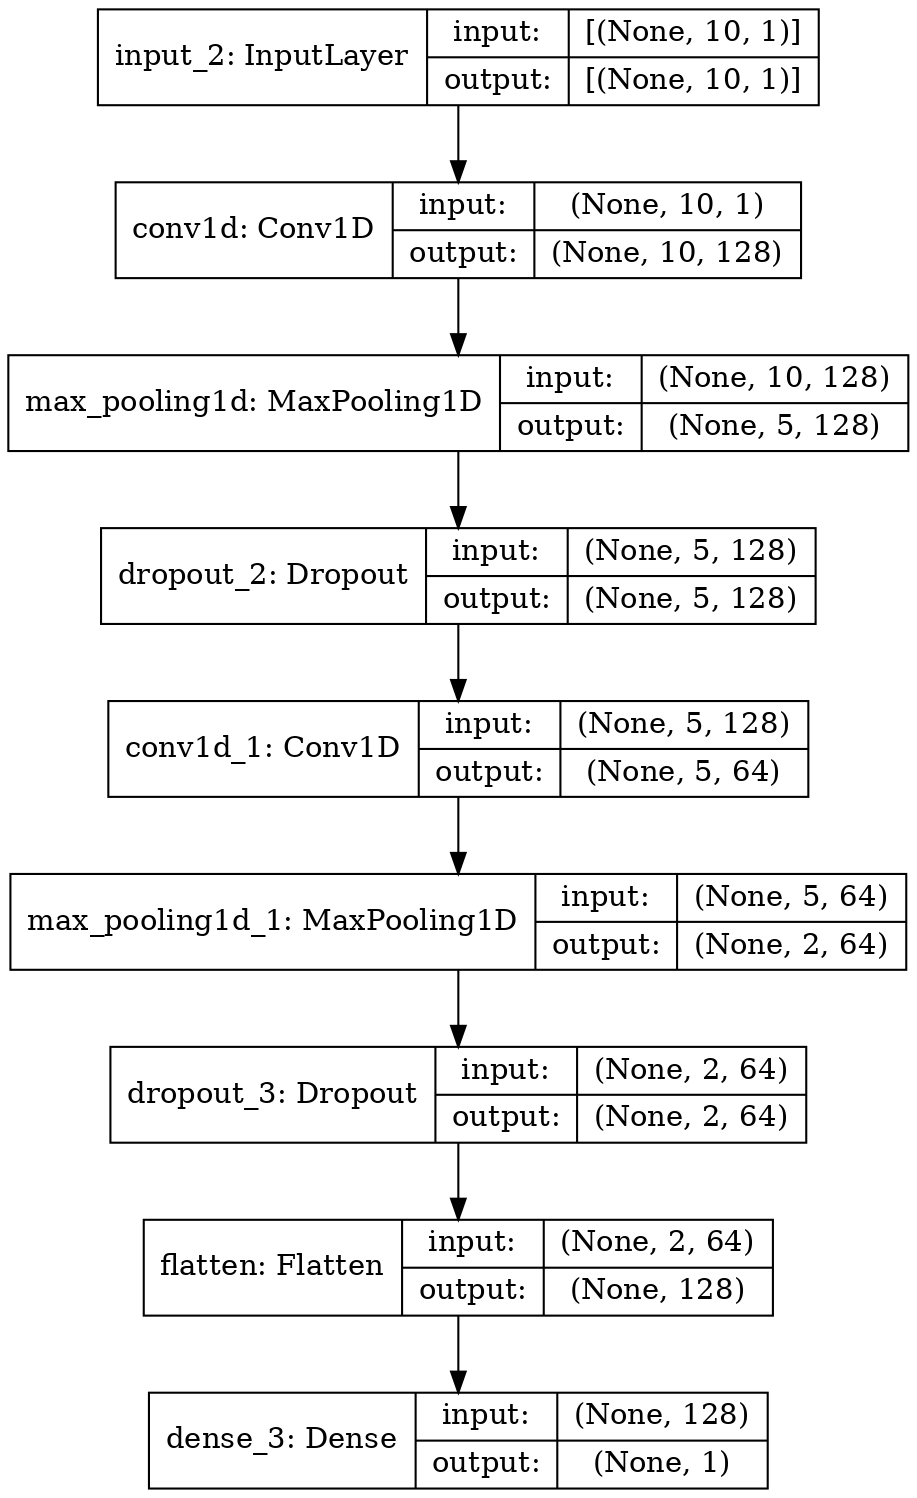

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 00037: early stopping


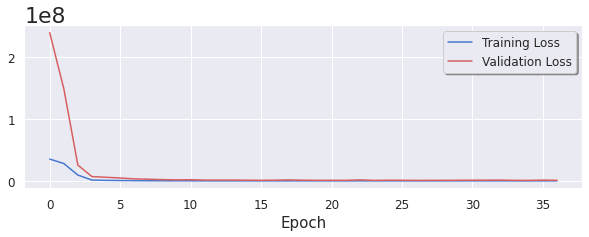

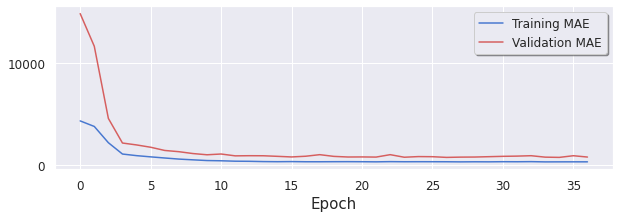

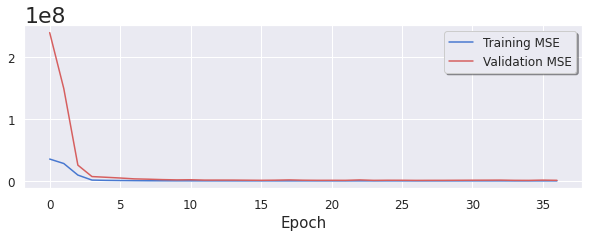

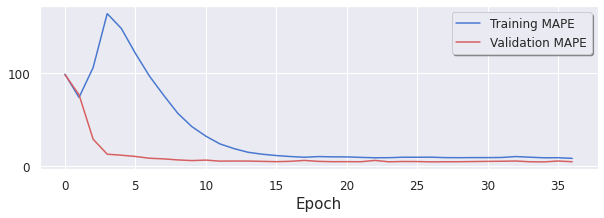

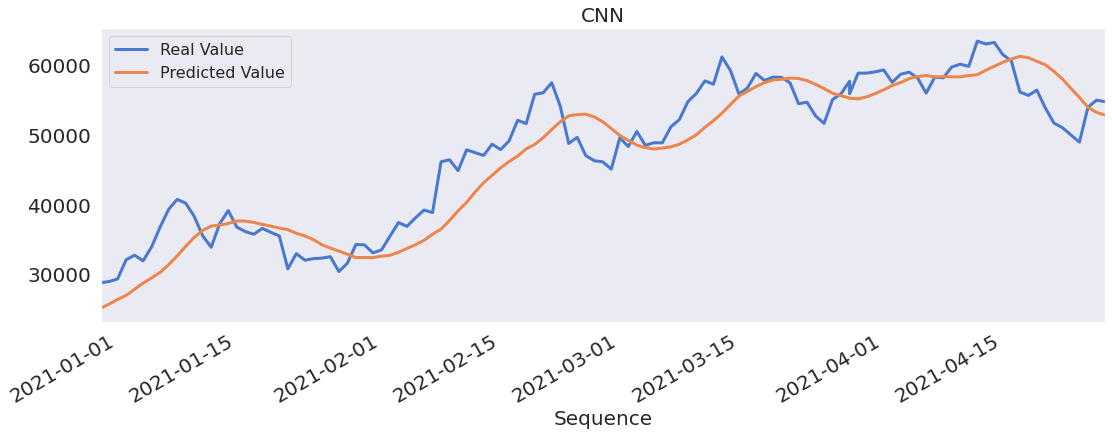

MAE           MSE  MAPE
Score 3,298.65 16,337,056.74  0.07

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.10               0.22       0.98   
p-value                                   0.03               0.10       0.14   
Used Lag                                  0.00              13.00        NaN   
Used Observations                       119.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,923.29                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        88.71          207.64           214.73   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        409.30               0.82  
p-value                                  0.00               0.47  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

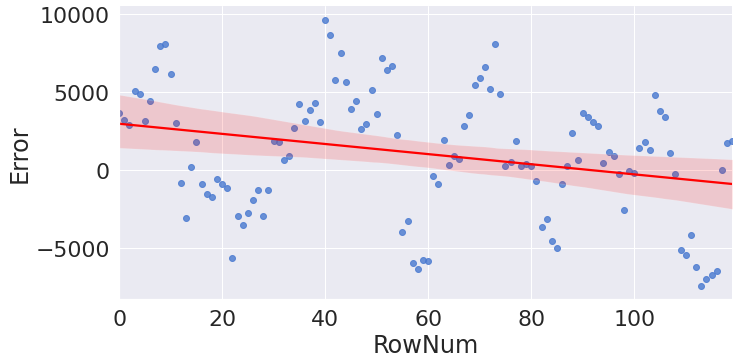

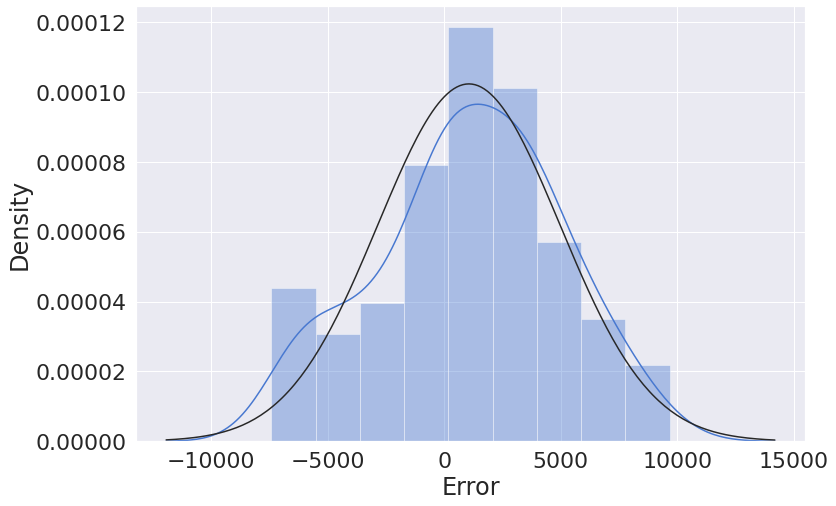

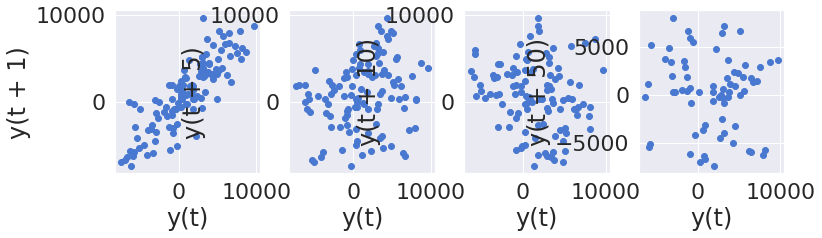

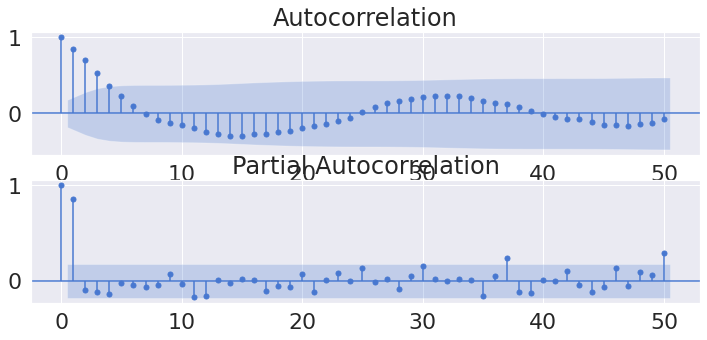

In [7]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','CryptoCurrency','Bitcoin.csv')
df = pd.read_csv(location, index_col='Date')
df.index = pd.to_datetime(df.index)
df = df[['Close']].copy()

# Reshape
df_X, df_Y = reshape_1Dto2Dseq(df, seq_length=SEQUENCE)
df_Y.columns = Y_colname
df = pd.concat([df_Y, df_X], axis=1)

# Preprocessing
X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
X_colname = X_test.columns

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# CNN
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = Conv1D(128, kernel_size=X_train.shape[1], padding='same', activation='relu')(inputs)
# hiddens = Conv1D(256, kernel_size=X_train.shape[1], padding='same', activation='relu')(hiddens)
hiddens = MaxPooling1D(pool_size=2)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = Conv1D(128, kernel_size=X_train.shape[1], padding='same', activation='relu')(hiddens)
hiddens = Conv1D(64, kernel_size=X_train.shape[1], padding='same', activation='relu')(hiddens)
hiddens = MaxPooling1D(pool_size=2)(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
outputs = Dense(1)(hiddens)
algo_CNN = Model(inputs, outputs)
algo_CNN.summary()
display(plot_model(algo_CNN, to_file=RESULT_LOCATION+'CNN.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'CNN.h5')]

algo_CNN.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_CNNfit = algo_CNN.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_CNNfit)

# Prediction
Y_pred = algo_CNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='CNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_CNN = Score.copy()
Y_pred_CNN = Y_pred.copy()
Error_CNN = ErrorResult.copy()

### Load Best Learning

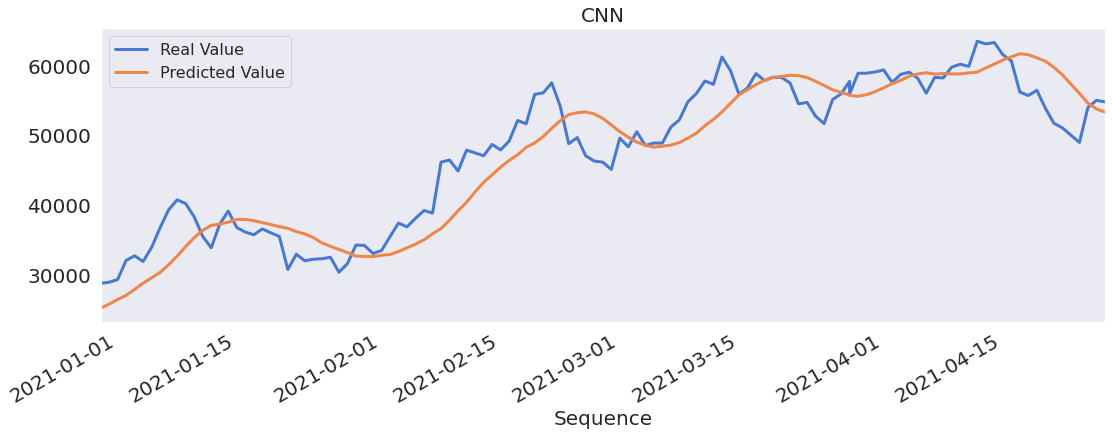

MAE           MSE  MAPE
Score 3,299.34 16,577,146.14  0.07

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.03               0.24       0.98   
p-value                                   0.03               0.10       0.16   
Used Lag                                  0.00              13.00        NaN   
Used Observations                       119.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,923.76                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        90.20          215.62           222.82   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        421.11               0.82  
p-value                                  0.00               0.47  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

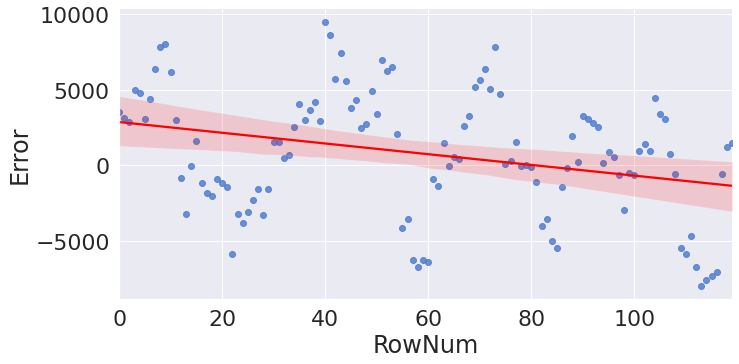

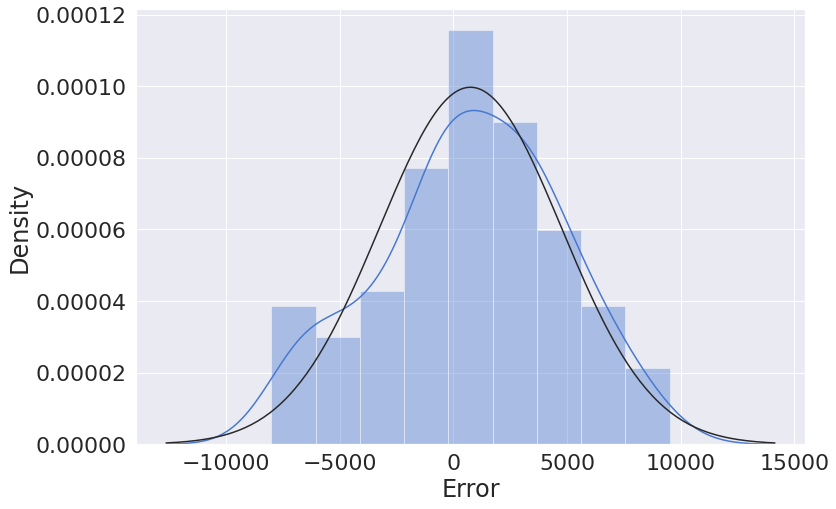

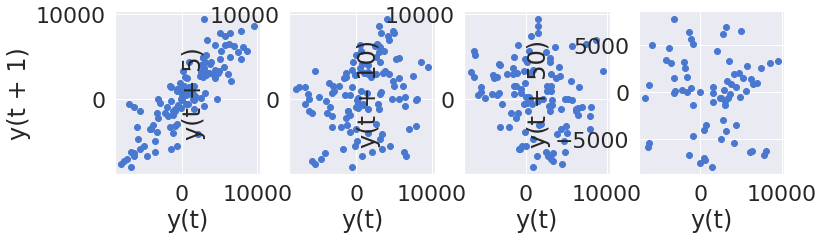

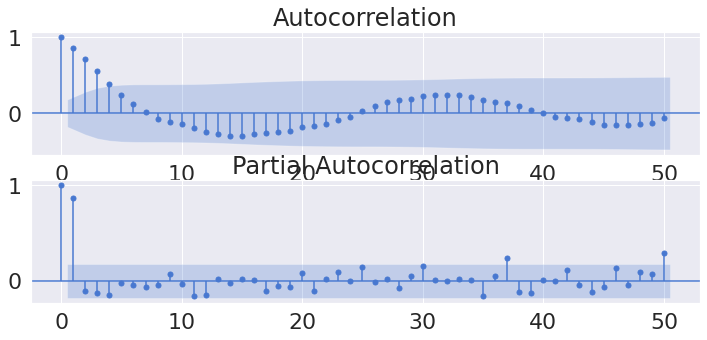

In [8]:
# Loading of Best Learning 
algo_CNN = load_model(RESULT_LOCATION+'CNN.h5')

# Prediction
Y_pred = algo_CNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='CNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_CNN = Score.copy()
Y_pred_CNN = Y_pred.copy()
Error_CNN = ErrorResult.copy()

## RNN

X_train: (2162, 10) Y_train: (2162, 1)
X_val: (120, 10) Y_val: (120, 1)
X_test: (120, 10) Y_test: (120, 1)
X_train: (2162, 10, 1) Y_train: (2162, 1)
X_val: (120, 10, 1) Y_val: (120, 1)
X_test: (120, 10, 1) Y_test: (120, 1)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10, 128)           16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 64)            12352     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 64)            0         
__________________________________

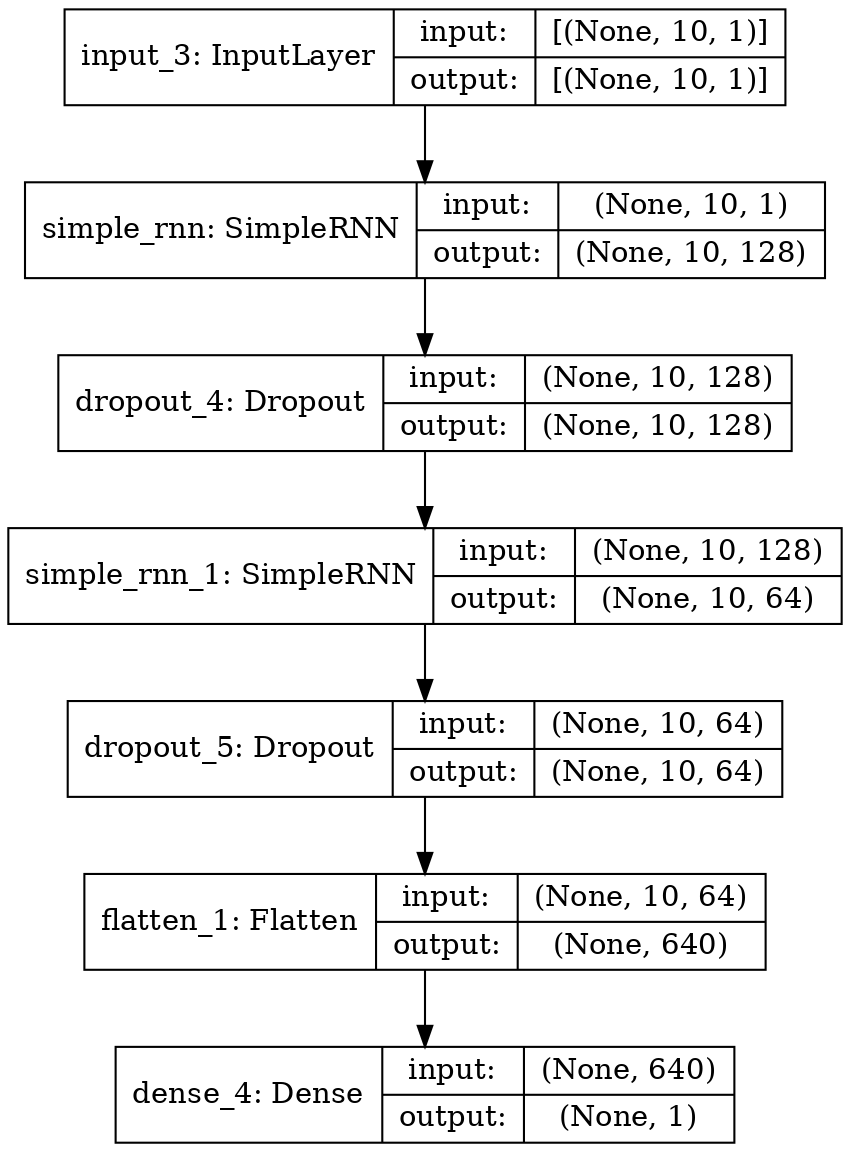

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 00016: early stopping


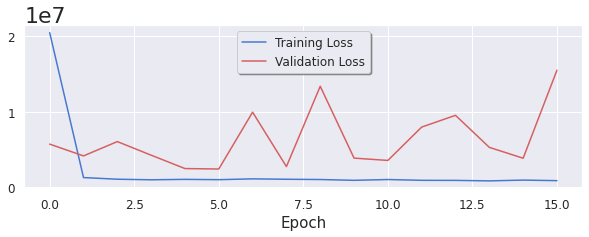

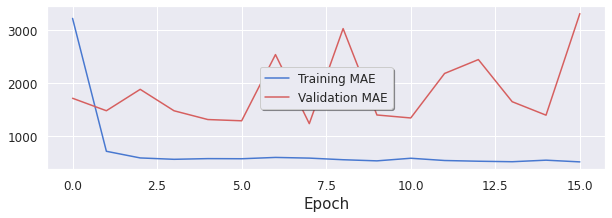

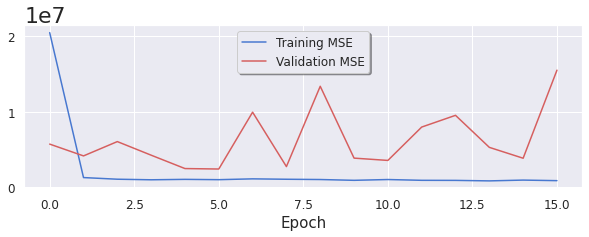

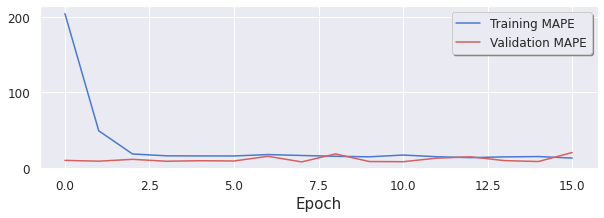

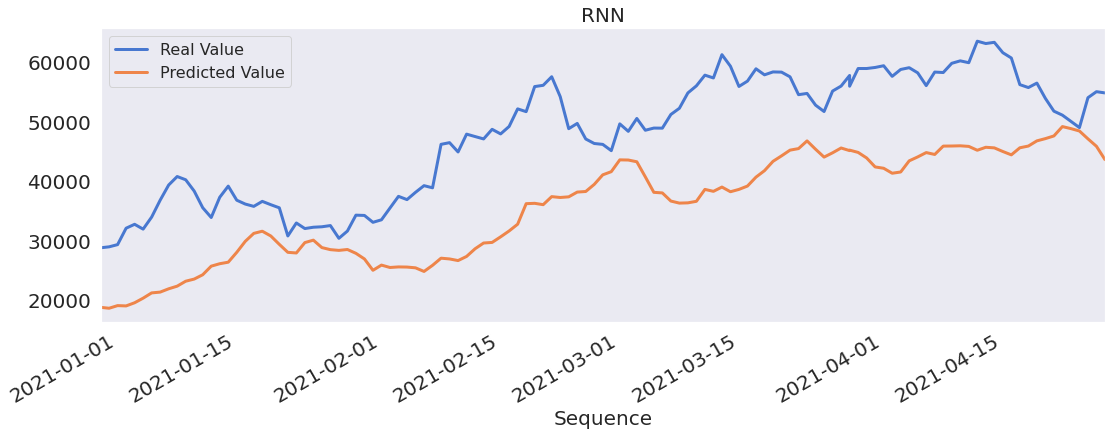

MAE            MSE  MAPE
Score 12,039.42 173,682,030.01  0.25

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.85               0.11       0.97   
p-value                                   0.00               0.10       0.01   
Used Lag                                  5.00              13.00        NaN   
Used Observations                       114.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,929.29                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       103.30          308.57           325.97   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        562.90               0.83  
p-value                                  0.00               0.51  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

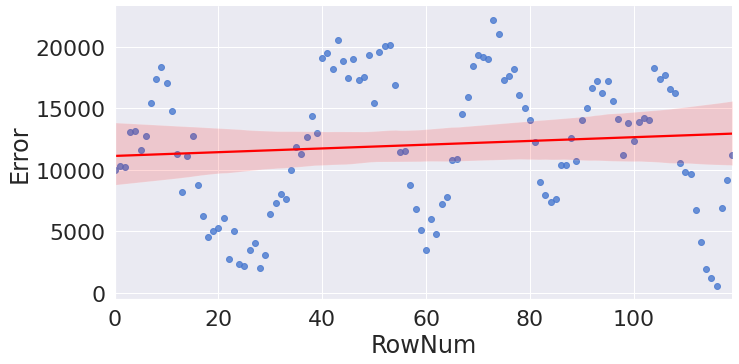

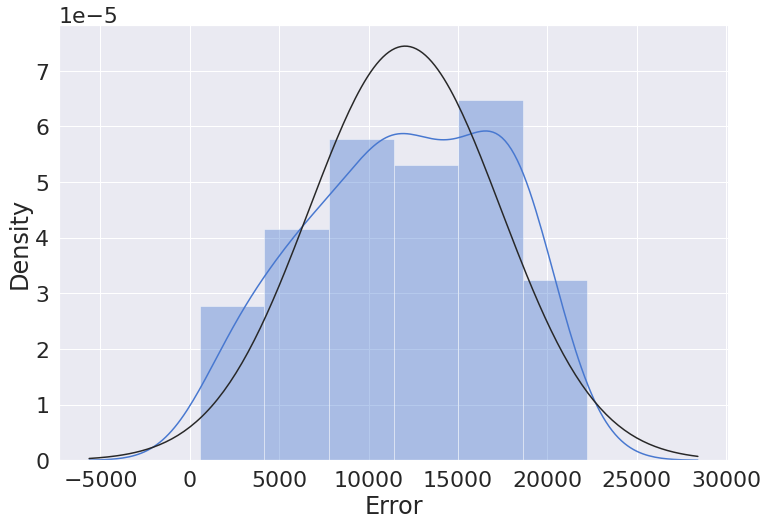

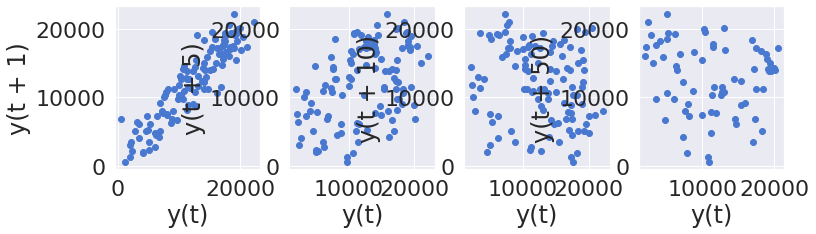

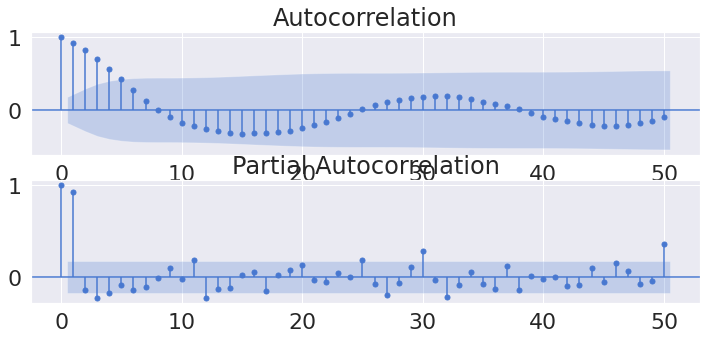

In [9]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','CryptoCurrency','Bitcoin.csv')
df = pd.read_csv(location, index_col='Date')
df.index = pd.to_datetime(df.index)
df = df[['Close']].copy()

# Reshape
df_X, df_Y = reshape_1Dto2Dseq(df, seq_length=SEQUENCE)
df_Y.columns = Y_colname
df = pd.concat([df_Y, df_X], axis=1)

# Preprocessing
X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
X_colname = X_test.columns

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# RNN
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = SimpleRNN(128, return_sequences=True, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = SimpleRNN(256, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = SimpleRNN(128, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = SimpleRNN(64, return_sequences=True, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = Flatten()(hiddens)
outputs = Dense(1)(hiddens)
algo_RNN = Model(inputs, outputs)
algo_RNN.summary()
display(plot_model(algo_RNN, to_file=RESULT_LOCATION+'RNN.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'RNN.h5')]

algo_RNN.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_RNNfit = algo_RNN.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_RNNfit)

# Prediction
Y_pred = algo_RNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='RNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_RNN = Score.copy()
Y_pred_RNN = Y_pred.copy()
Error_RNN = ErrorResult.copy()

### Load Best Learning

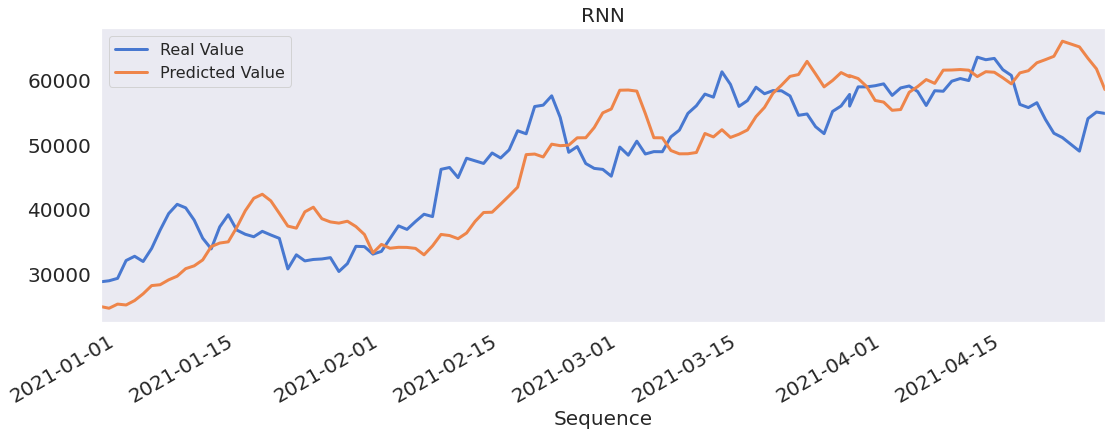

MAE           MSE  MAPE
Score 5,367.77 40,042,647.03  0.12

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.13               0.27       0.98   
p-value                                   0.02               0.10       0.03   
Used Lag                                 12.00              13.00        NaN   
Used Observations                       107.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,941.55                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       105.69          321.65           341.51   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        632.99               0.83  
p-value                                  0.00               0.51  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

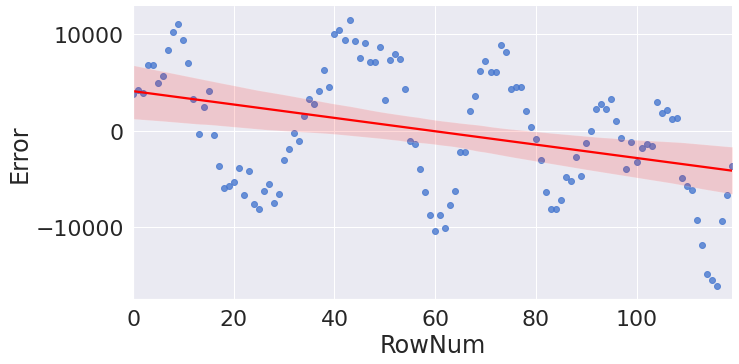

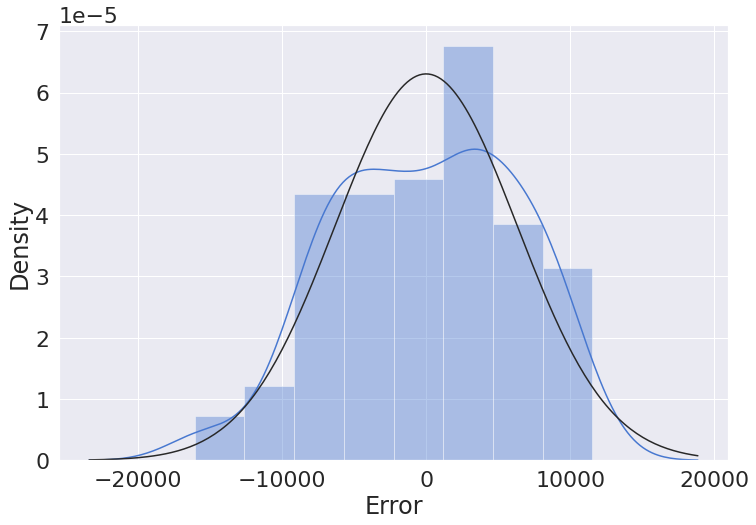

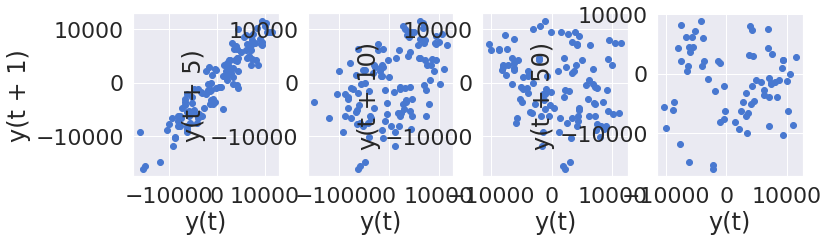

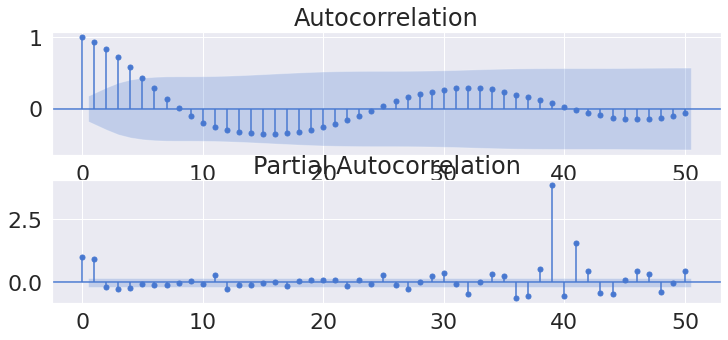

In [10]:
# Loading of Best Learning 
algo_RNN = load_model(RESULT_LOCATION+'RNN.h5')

# Prediction
Y_pred = algo_RNN.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='RNN', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_RNN = Score.copy()
Y_pred_RNN = Y_pred.copy()
Error_RNN = ErrorResult.copy()

## LSTM

X_train: (2162, 10) Y_train: (2162, 1)
X_val: (120, 10) Y_val: (120, 1)
X_test: (120, 10) Y_test: (120, 1)
X_train: (2162, 10, 1) Y_train: (2162, 1)
X_val: (120, 10, 1) Y_val: (120, 1)
X_test: (120, 10, 1) Y_test: (120, 1)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
__________________________________

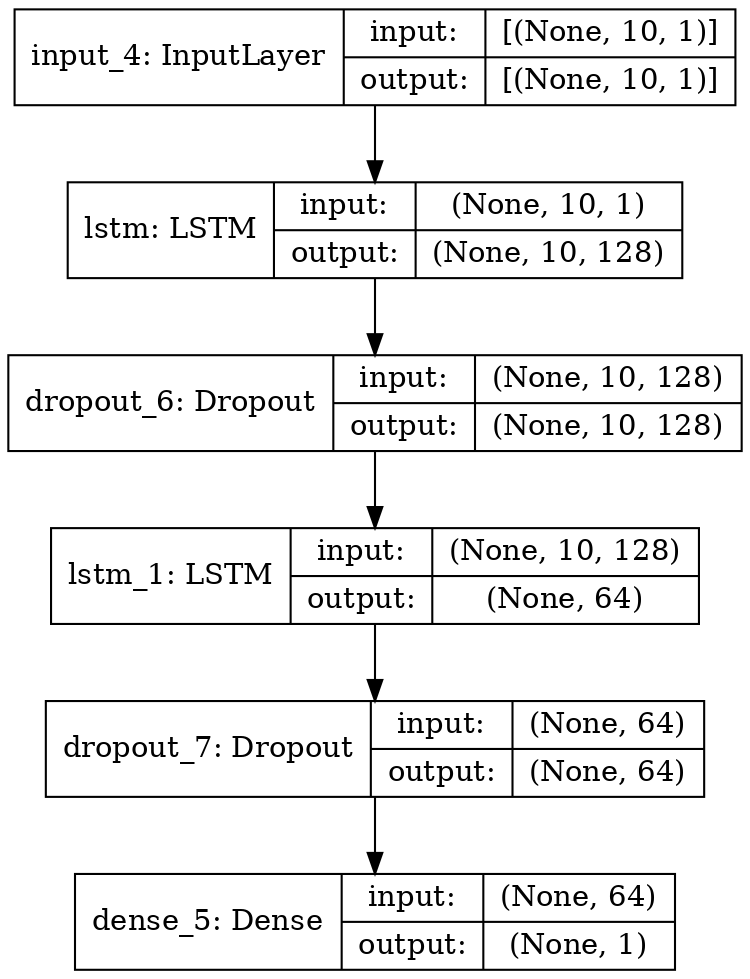

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 00028: early stopping


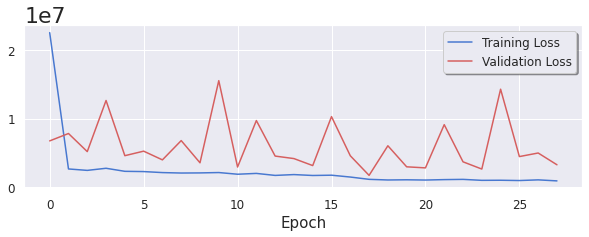

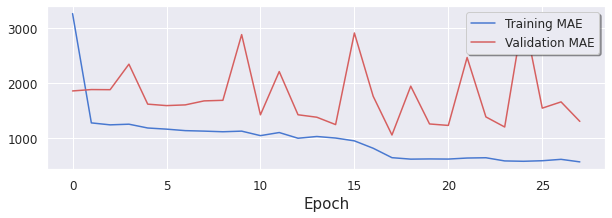

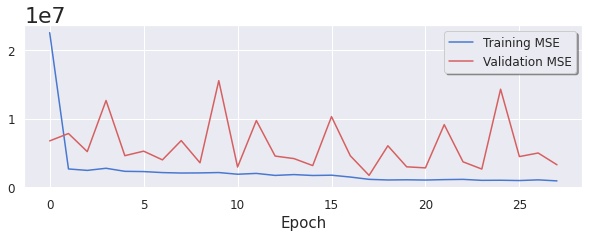

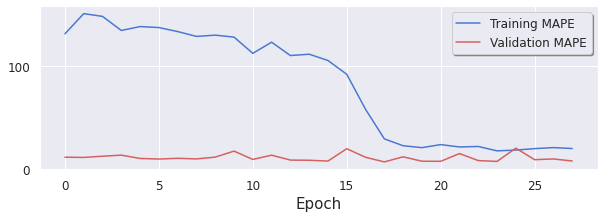

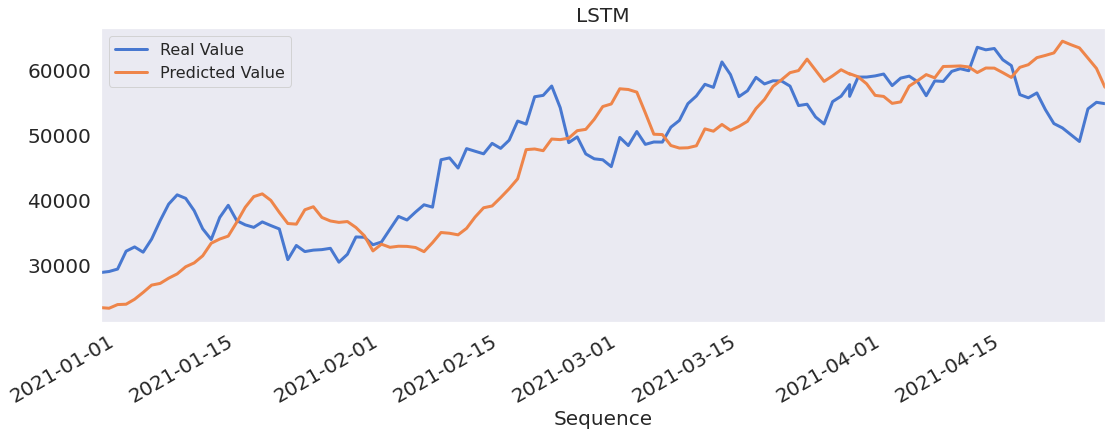

MAE           MSE  MAPE
Score 5,279.27 39,266,345.28  0.12

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.12               0.30       0.98   
p-value                                   0.03               0.10       0.05   
Used Lag                                 11.00              13.00        NaN   
Used Observations                       108.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,938.21                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       105.83          324.24           344.02   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        639.77               0.74  
p-value                                  0.00               0.30  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

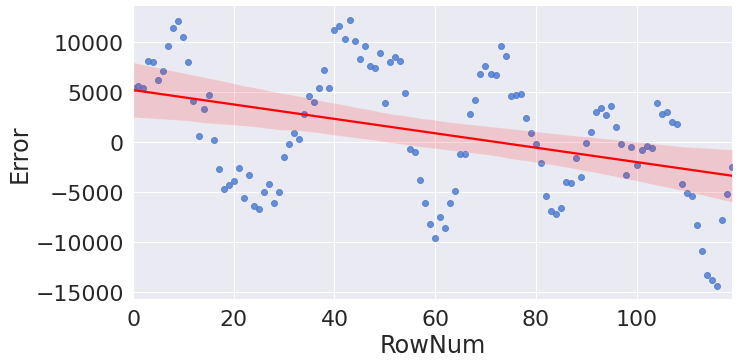

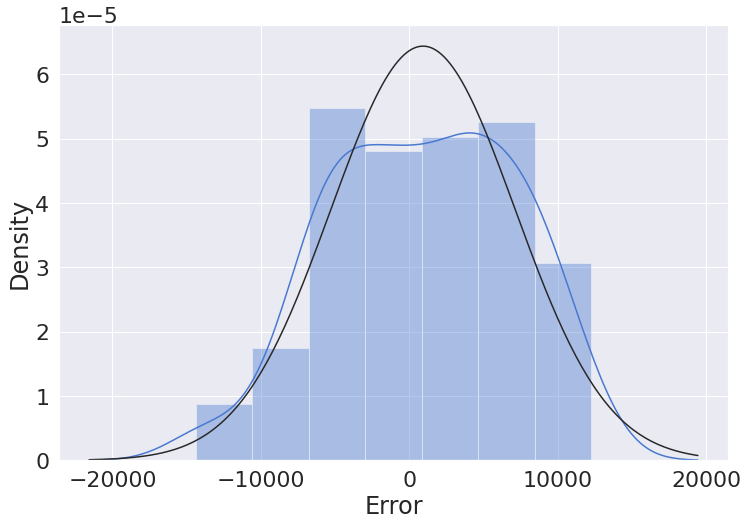

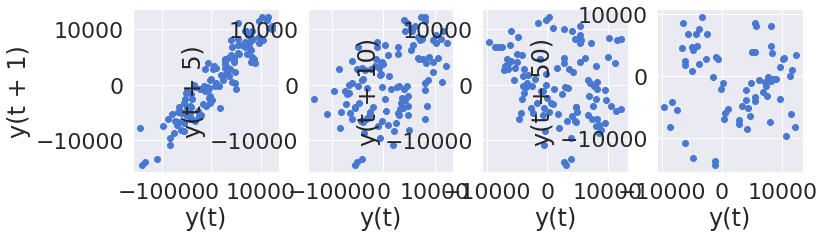

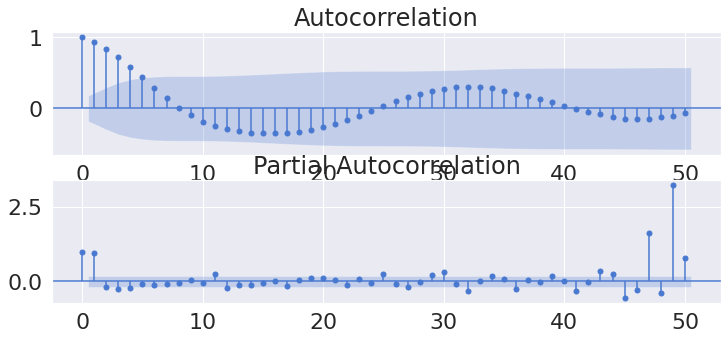

In [11]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','CryptoCurrency','Bitcoin.csv')
df = pd.read_csv(location, index_col='Date')
df.index = pd.to_datetime(df.index)
df = df[['Close']].copy()

# Reshape
df_X, df_Y = reshape_1Dto2Dseq(df, seq_length=SEQUENCE)
df_Y.columns = Y_colname
df = pd.concat([df_Y, df_X], axis=1)

# Preprocessing
X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
X_colname = X_test.columns

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# LSTM
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = LSTM(128, return_sequences=True, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = LSTM(256, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = LSTM(128, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = LSTM(64, return_sequences=False, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1)(hiddens)
algo_LSTM = Model(inputs, outputs)
algo_LSTM.summary()
display(plot_model(algo_LSTM, to_file=RESULT_LOCATION+'LSTM.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'LSTM.h5')]

algo_LSTM.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_LSTMfit = algo_LSTM.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_LSTMfit)

# Prediction
Y_pred = algo_LSTM.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='LSTM', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_LSTM = Score.copy()
Y_pred_LSTM = Y_pred.copy()
Error_LSTM = ErrorResult.copy()

### Load Best Learning

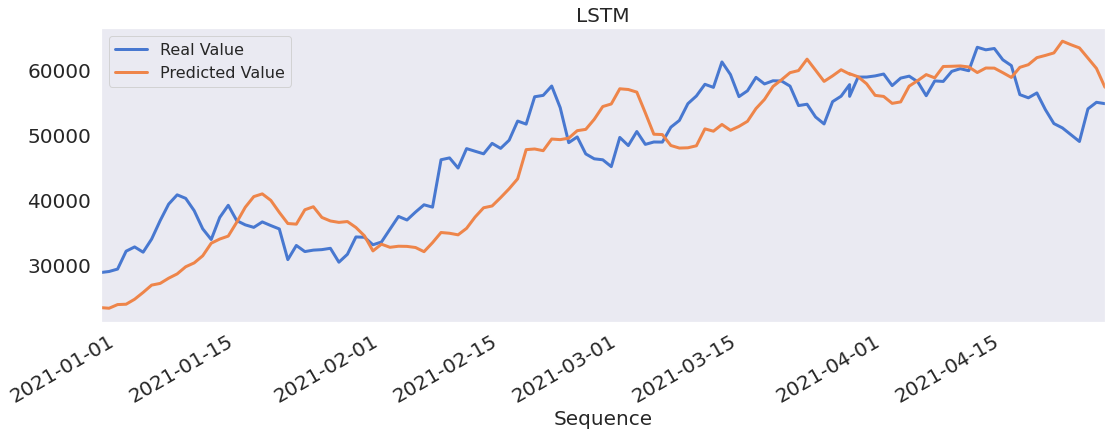

MAE           MSE  MAPE
Score 5,279.27 39,266,345.28  0.12

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.12               0.30       0.98   
p-value                                   0.03               0.10       0.05   
Used Lag                                 11.00              13.00        NaN   
Used Observations                       108.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,938.21                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       105.83          324.24           344.02   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        639.77               0.74  
p-value                                  0.00               0.30  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

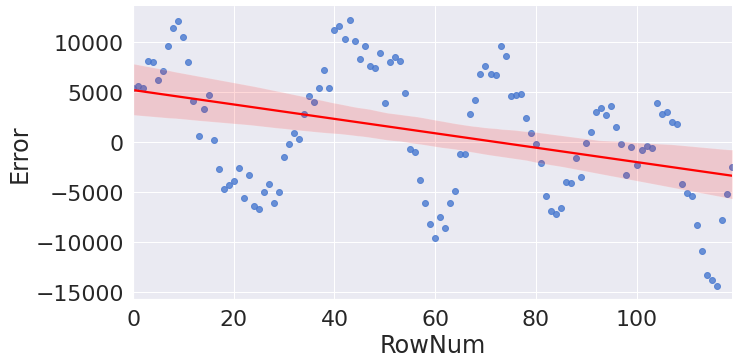

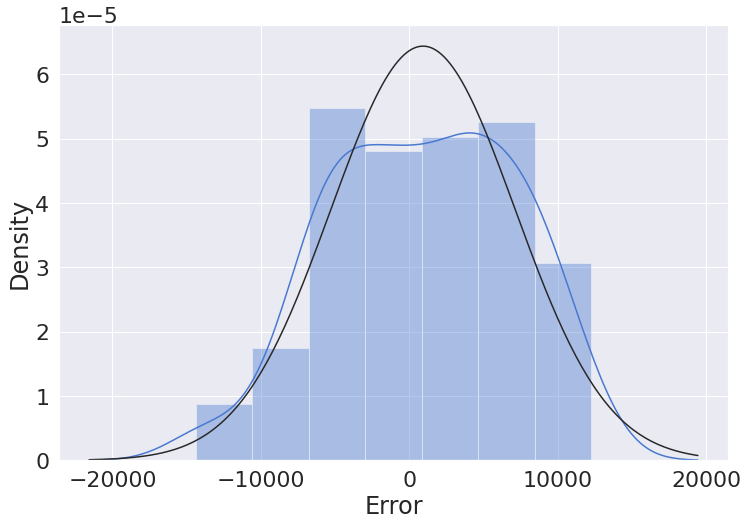

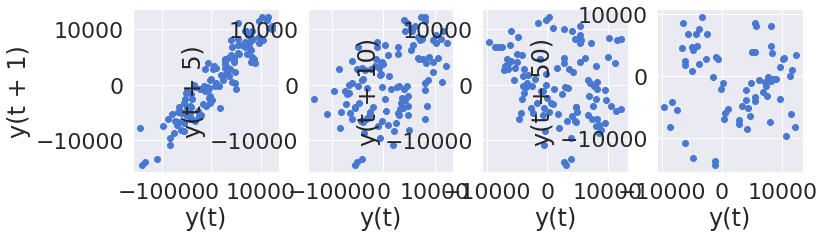

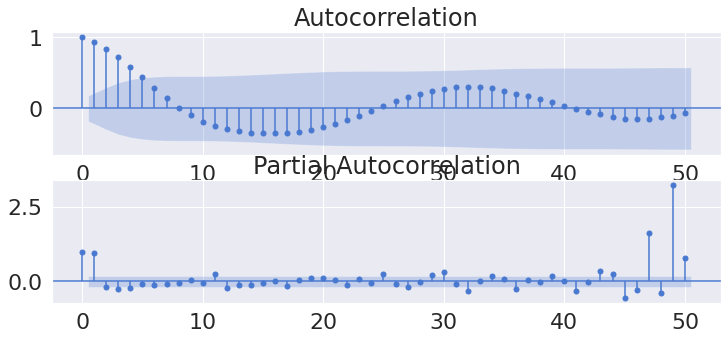

In [12]:
# Loading of Best Learning 
algo_LSTM = load_model(RESULT_LOCATION+'LSTM.h5')

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='LSTM', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_LSTM = Score.copy()
Y_pred_LSTM = Y_pred.copy()
Error_LSTM = ErrorResult.copy()

## GRU

X_train: (2162, 10) Y_train: (2162, 1)
X_val: (120, 10) Y_val: (120, 1)
X_test: (120, 10) Y_test: (120, 1)
X_train: (2162, 10, 1) Y_train: (2162, 1)
X_val: (120, 10, 1) Y_val: (120, 1)
X_test: (120, 10, 1) Y_test: (120, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 10, 128)           50304     
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
__________________________________

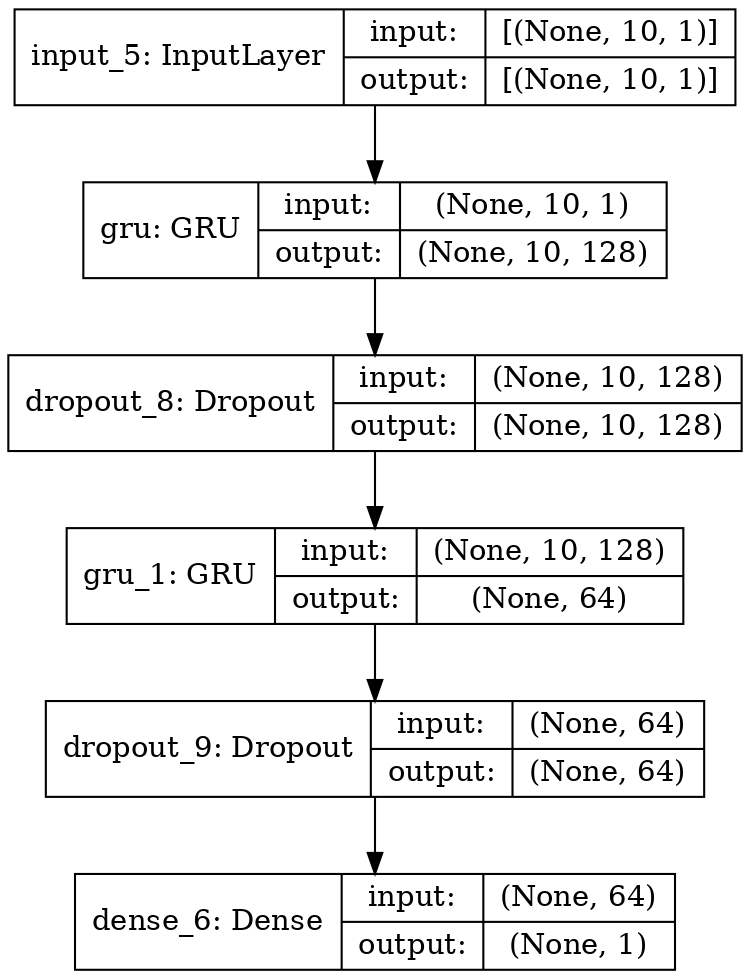

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 00024: early stopping


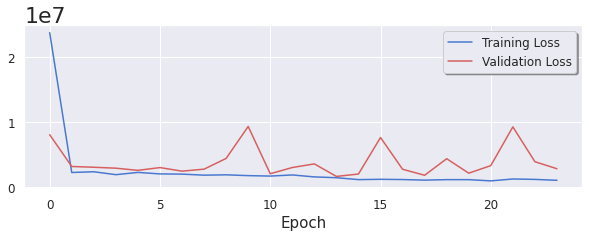

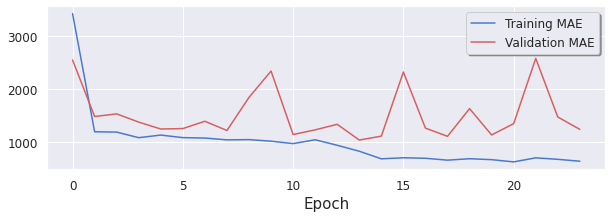

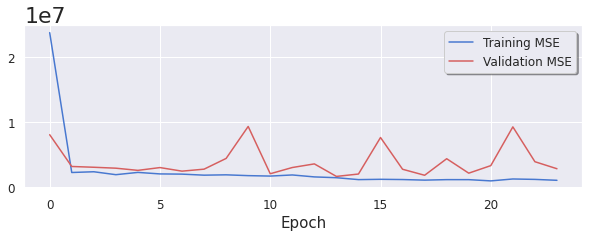

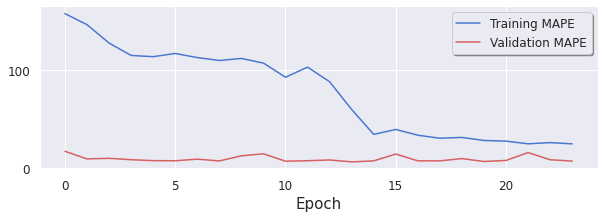

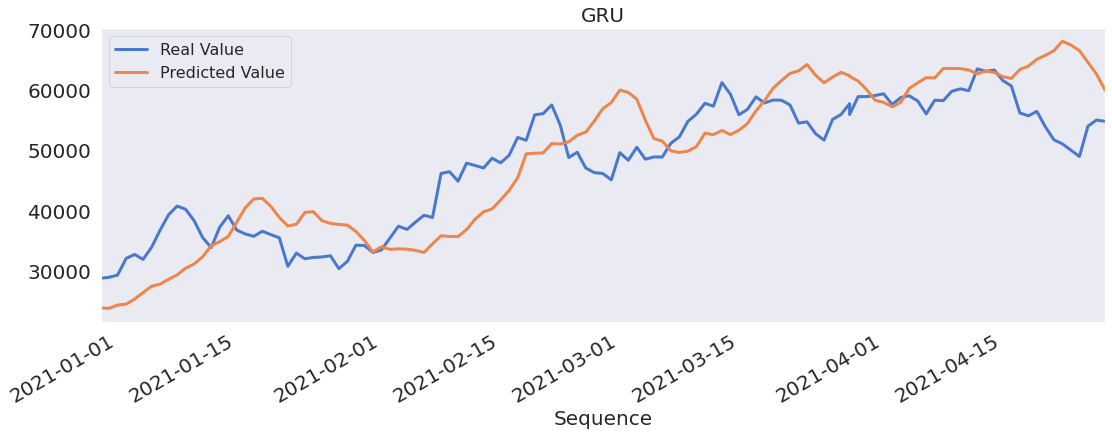

MAE           MSE  MAPE
Score 5,687.10 46,162,299.87  0.13

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.49               0.41       0.98   
p-value                                   0.01               0.07       0.06   
Used Lag                                  3.00              13.00        NaN   
Used Observations                       116.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,940.32                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       107.62          337.31           357.77   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        602.19               0.75  
p-value                                  0.00               0.32  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

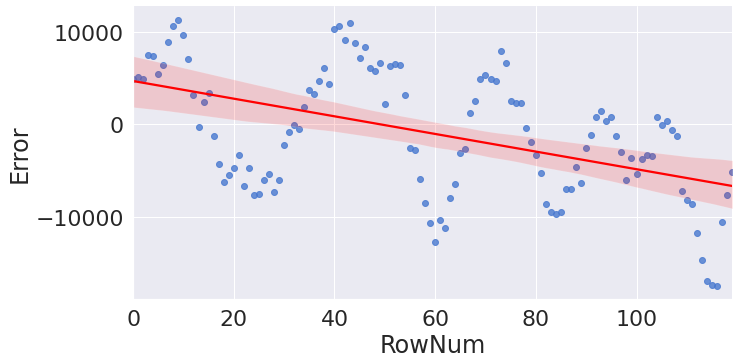

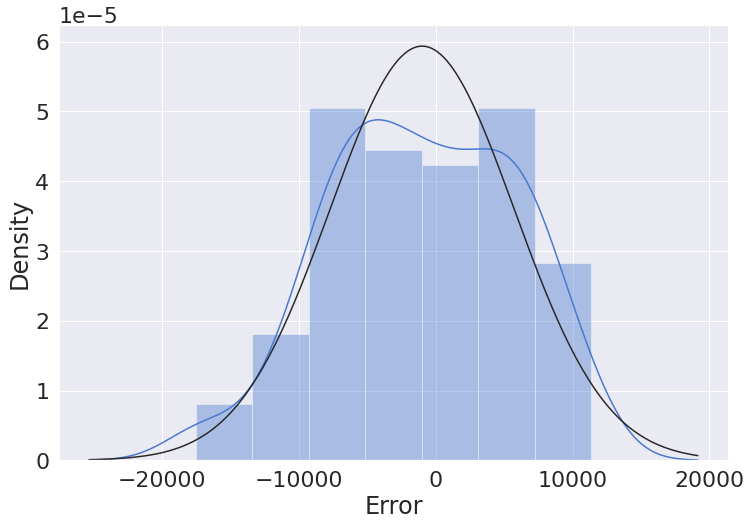

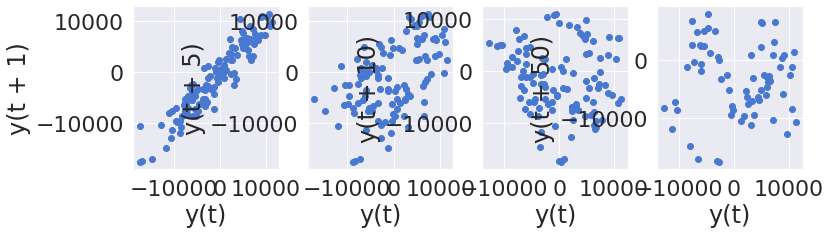

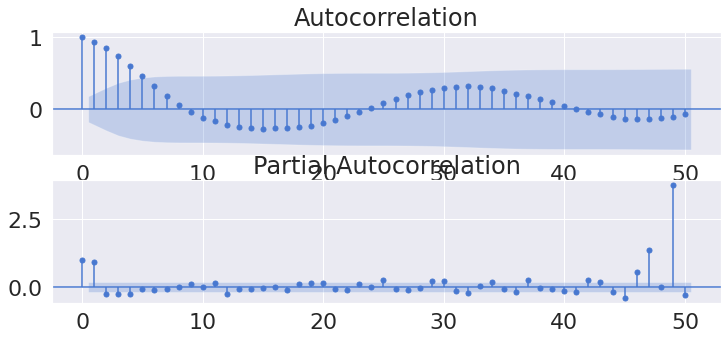

In [13]:
# Data Loading
location = os.path.join(os.getcwd(),'Data','CryptoCurrency','Bitcoin.csv')
df = pd.read_csv(location, index_col='Date')
df.index = pd.to_datetime(df.index)
df = df[['Close']].copy()

# Reshape
df_X, df_Y = reshape_1Dto2Dseq(df, seq_length=SEQUENCE)
df_Y.columns = Y_colname
df = pd.concat([df_Y, df_X], axis=1)

# Preprocessing
X_train, X_test, \
Y_train, Y_test = datasplit_timeseries_ratio(df, Y_colname, 
                                             test_ratio=TEST_RATIO, shape_show=False)
X_val, X_test, \
Y_val, Y_test = datasplit_timeseries_ratio(pd.concat([X_test, Y_test], axis=1), Y_colname, 
                                           test_ratio=0.5, shape_show=False)
X_colname = X_test.columns

# Scaling
scaler_fit = scaler.fit(X_train)
X_train = scaler_fit.transform(X_train)
X_val = scaler_fit.transform(X_val)
X_test = scaler_fit.transform(X_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Reshape
X_test_old = X_test.copy()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
hiddens = GRU(128, return_sequences=True, activation='relu')(inputs)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = GRU(256, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
# hiddens = GRU(128, return_sequences=True, activation='relu')(hiddens)
# hiddens = Dropout(DROPOUT_RATIO)(hiddens)
hiddens = GRU(64, return_sequences=False, activation='relu')(hiddens)
hiddens = Dropout(DROPOUT_RATIO)(hiddens)
outputs = Dense(1)(hiddens)
algo_GRU = Model(inputs, outputs)
algo_GRU.summary()
display(plot_model(algo_GRU, to_file=RESULT_LOCATION+'GRU.png', 
                   show_shapes=True, dpi=RESULT_DPI))

# Learning
CALLBACK = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
            callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    patience=EARLYSTOP_PATIENT, verbose=1),
            callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_best_only=True, 
                                      filepath=RESULT_LOCATION+'GRU.h5')]

algo_GRU.compile(loss='mse', optimizer='adam',
                 metrics=['mae', 'mse', 'mape'])
algo_GRUfit = algo_GRU.fit(X_train, Y_train, 
                           batch_size=BATCH_SIZE, epochs=EPOCHS,
                           validation_data=(X_val, Y_val),
                           verbose=VERBOSE,
                           callbacks=[CALLBACK])
evaluation_reg_LearningPlot(algo_GRUfit)

# Prediction
Y_pred = algo_GRU.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, index=Y_test.index, columns=Y_colname)

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='GRU', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_GRU = Score.copy()
Y_pred_GRU = Y_pred.copy()
Error_GRU = ErrorResult.copy()

### Load Best Learning

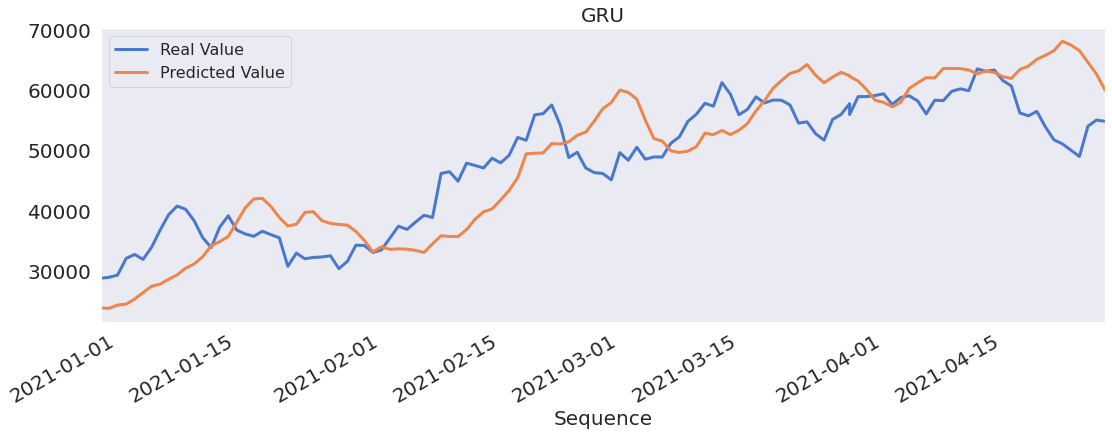

MAE           MSE  MAPE
Score 5,687.10 46,162,299.87  0.13

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                          -3.49               0.41       0.98   
p-value                                   0.01               0.07       0.06   
Used Lag                                  3.00              13.00        NaN   
Used Observations                       116.00                NaN        NaN   
Critical Value(1%)                       -3.49                NaN        NaN   
Maximum Information Criteria          1,940.32                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       107.62          337.31           357.77   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                        602.19               0.75  
p-value                                  0.00               0.32  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

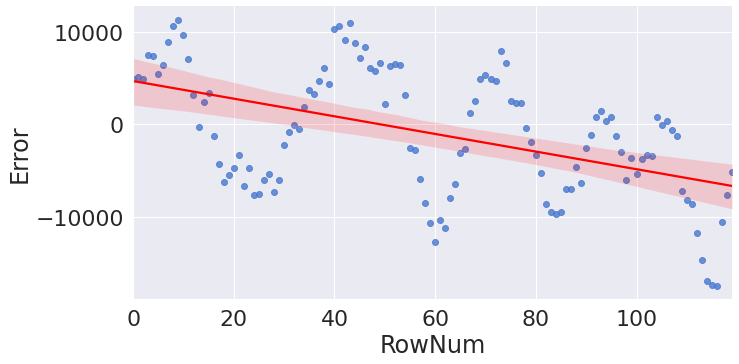

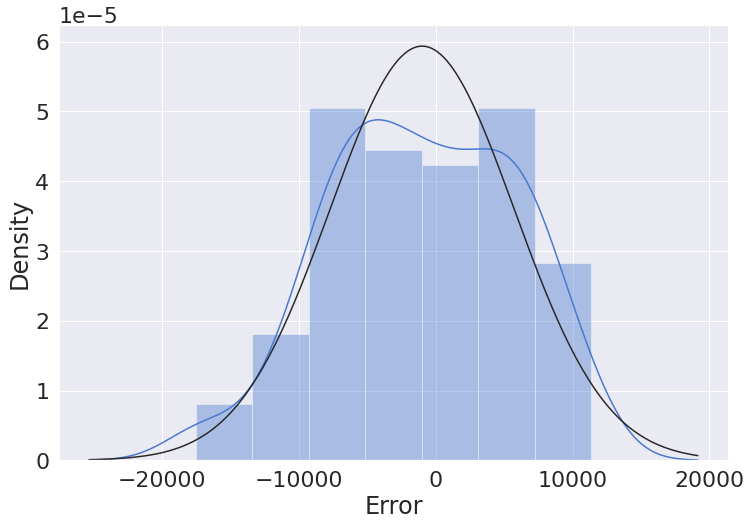

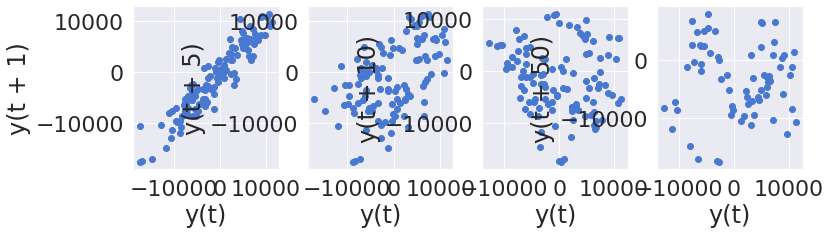

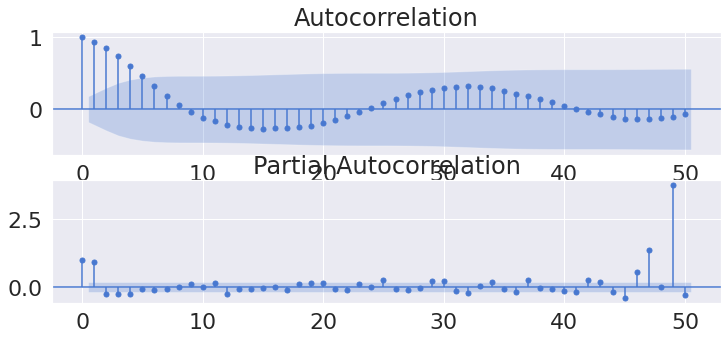

In [14]:
# Loading of Best Learning 
algo_GRU = load_model(RESULT_LOCATION+'GRU.h5')

# Evaluation
evaluation_reg_PredPlot(Y_test, Y_pred, title='GRU', ylabel='')
Score, Resid_te = evaluation_reg_MAE_MSE_MAPE(Y_test, Y_pred)
display(Score)

# Error Analysis
Resid_te.rename(columns={Y_colname[0]:'Error'}, inplace=True)
X_test_old = pd.DataFrame(X_test_old, index=Y_test.index, columns=X_colname)
ErrorResult = error_analysis(Resid_te, X_test_old, graph_on=True)
display(ErrorResult)

# Summary
Score_GRU = Score.copy()
Y_pred_GRU = Y_pred.copy()
Error_GRU = ErrorResult.copy()

# Result Summary

In [15]:
Score_Final = pd.concat([Score_MLP, Score_CNN, Score_RNN, Score_LSTM, Score_GRU], axis=0)
Score_Final.index = ALGO_NAMES
Score_Final

MAE           MSE  MAPE
MLP  3,434.79 17,306,766.39  0.08
CNN  3,299.34 16,577,146.14  0.07
RNN  5,367.77 40,042,647.03  0.12
LSTM 5,279.27 39,266,345.28  0.12
GRU  5,687.10 46,162,299.87  0.13

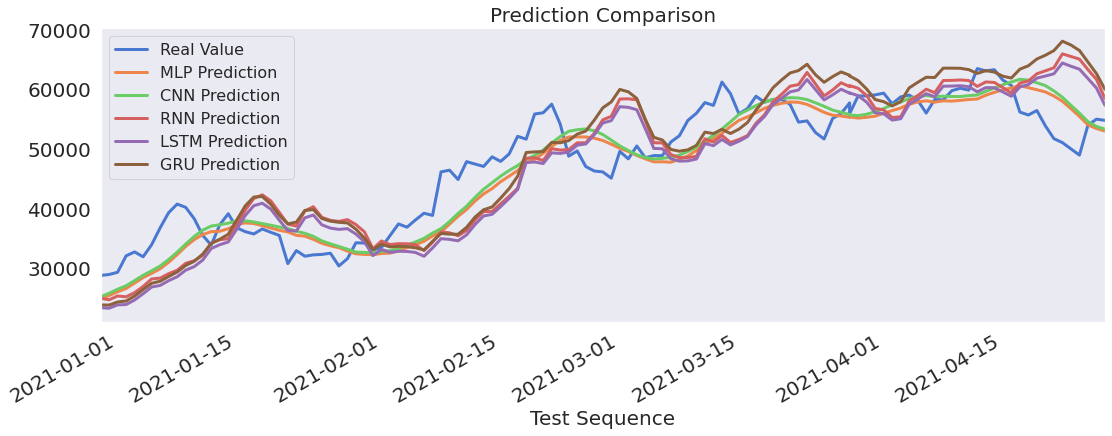

In [16]:
Y_pred_Final = pd.concat([Y_test, Y_pred_MLP, Y_pred_CNN, Y_pred_RNN, Y_pred_LSTM, Y_pred_GRU], axis=1)
Y_pred_Final.columns = ['Real Value']+[i+' Prediction' for i in ALGO_NAMES]
Y_pred_Final.plot(kind='line', figsize=(18,6), linewidth=3, fontsize=20,
                  xlim=(Y_pred_Final.index.min(),Y_pred_Final.index.max()))
plt.title('Prediction Comparison', fontsize=20)
plt.xlabel('Test Sequence', fontsize=20)
plt.ylabel('', fontsize=20)
plt.legend(fontsize=16)
plt.grid()
plt.show()

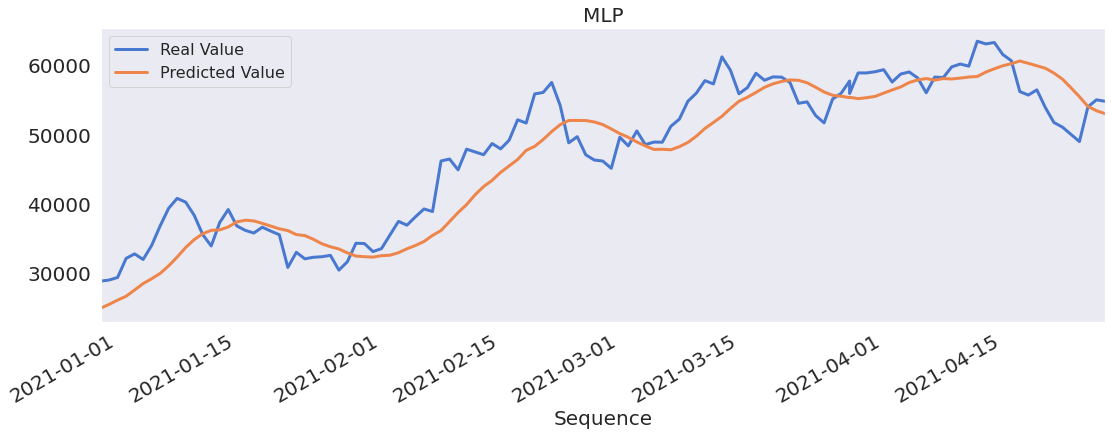

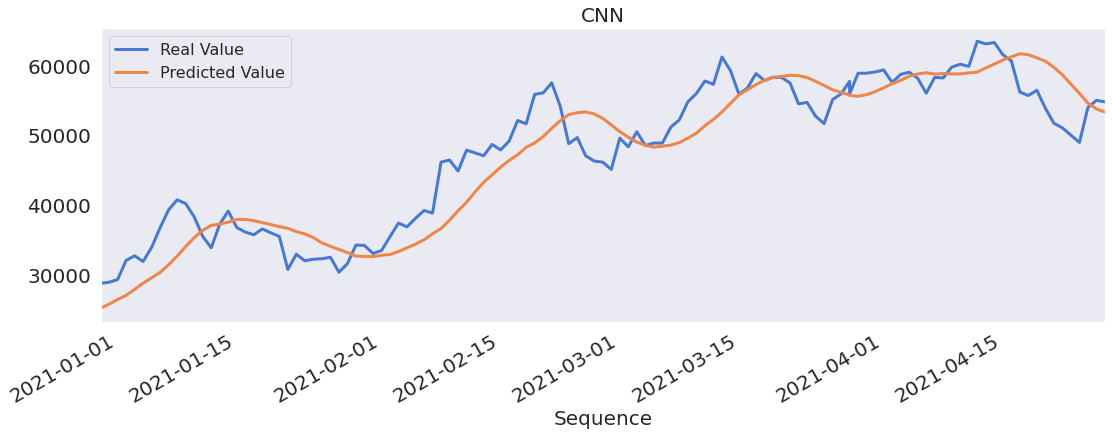

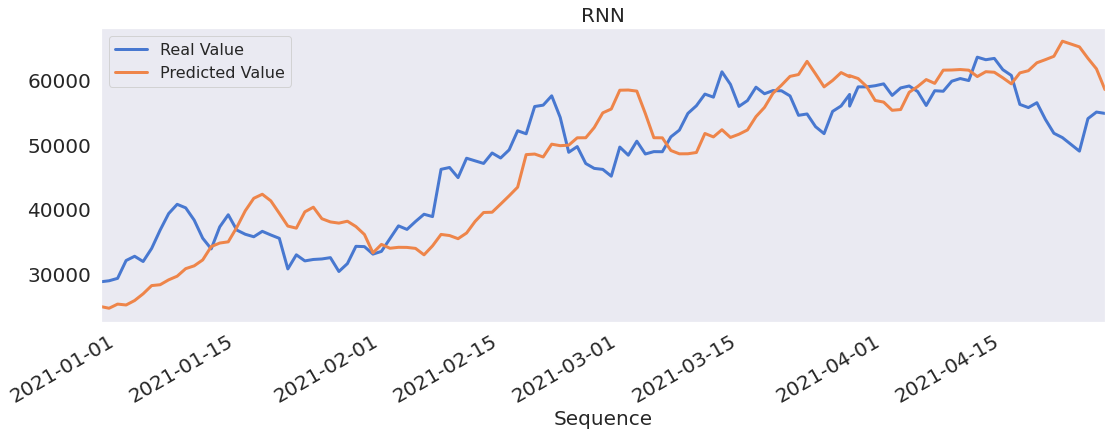

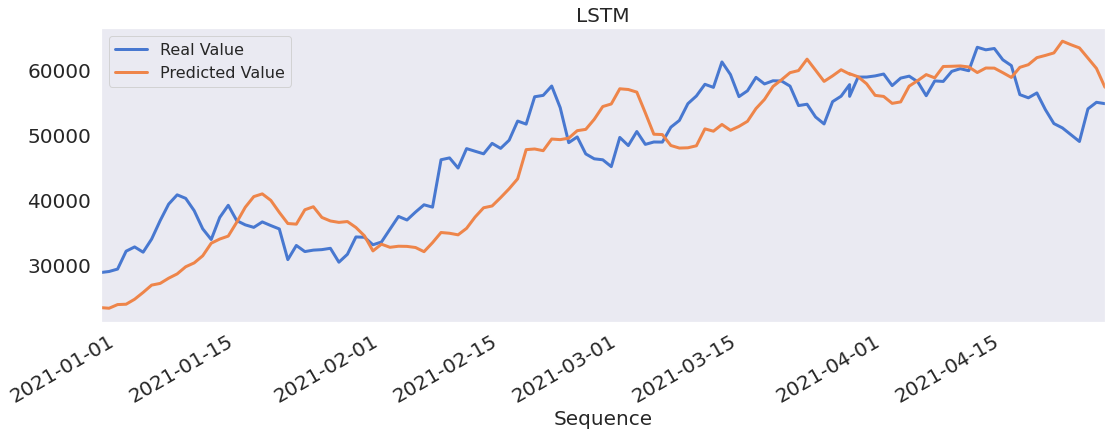

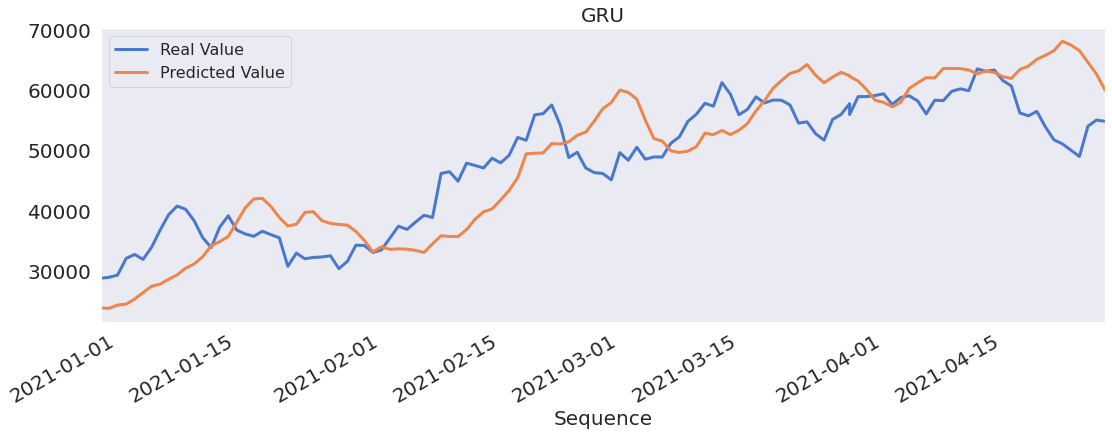

In [17]:
evaluation_reg_PredPlot(Y_test, Y_pred_MLP, title=ALGO_NAMES[0], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_CNN, title=ALGO_NAMES[1], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_RNN, title=ALGO_NAMES[2], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_LSTM, title=ALGO_NAMES[3], ylabel='')
evaluation_reg_PredPlot(Y_test, Y_pred_GRU, title=ALGO_NAMES[4], ylabel='')